# Applying the bilinear system identification Landau-Zener 

In [1]:
from qutip import *
import matplotlib.pyplot as plt
from bi_sys_id_quantum import *

In [2]:
def get_quantum_expectation(pulse, times):
    """
    Calculate the time-series for the expectation value of a quantum observable 
    pulse - a function of two arguments
    """
    Hamiltonian = [sigmaz(), [sigmax(), pulse]]
    
    return mesolve(
        Hamiltonian, basis(2, 0), times, [], [0.001 * sigmaz() + sigmax()]
    ).expect[0]

In [3]:
p = 100
dt = 0.01
F = 20.

times = dt * np.arange(500)

In [4]:
original_responses = [
    get_quantum_expectation(
        lambda t, args: F * (t < N * dt), 
        times
    ) for N in range(1, p + 1)
]

original_responses = np.array(original_responses)

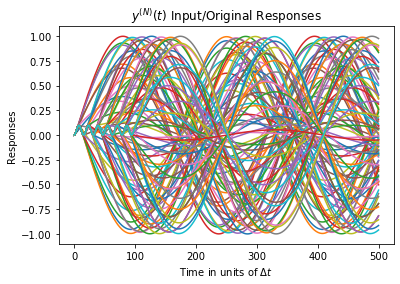

In [5]:
plt.title("$y^{(N)}(t)$ Input/Original Responses")
plt.plot(original_responses.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("Responses")
plt.savefig('input.pdf')
#plt.xlim(0, 200)
plt.show()

In [6]:
reconstructed = bi_sys_id_my_version(
    original_responses, 
    alpha = int(original_responses.shape[1] / 2),
    dt = dt,
    v = [F],
    #rank=4
)

In [7]:
# if isfor x in reconstructed]
reconstructed

Reconstructed(Ac=array([[-1.05159098e-01, -2.00354971e+00, -5.70393254e-02],
       [ 2.00354971e+00,  1.05613226e-01,  9.49858033e-03],
       [-5.70393254e-02, -9.49858033e-03, -4.54481561e-04]]), C=array([[-0.45507536, -0.45190177, -0.04460385]]), Nc=[array([[-2.28286911e-01,  1.98928281e+00,  7.02973857e+01],
       [ 2.31497845e-01, -2.01040405e+00, -7.10119612e+01],
       [-3.54544408e-02,  9.18289538e-02,  2.23869148e+00]])], x0=array([[ 0.00011119],
       [ 0.00092821],
       [-0.03296269]]))

In [8]:
reconstructed_responses = get_training_responses(reconstructed, times, p, [F])

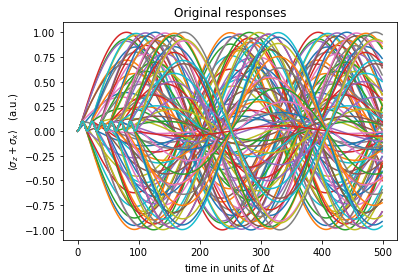

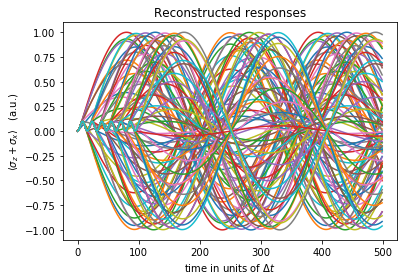

In [9]:
plt.title("Original responses")
plt.plot(original_responses.T)
plt.xlabel("time in units of $\Delta t$")
plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")
plt.savefig('input.pdf')
plt.show()

plt.title("Reconstructed responses")
plt.plot(reconstructed_responses.T)
plt.xlabel("time in units of $\Delta t$")
plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")
plt.savefig('response.pdf')
plt.show()

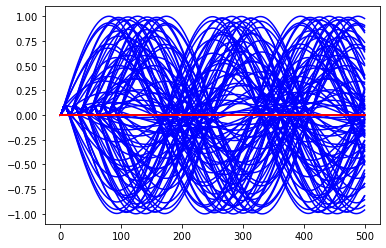

In [10]:
plt.plot(reconstructed_responses.T, 'b')
plt.plot(original_responses.T - reconstructed_responses.T.real, 'r')
#plt.ylim([-1, 1.])
plt.show()

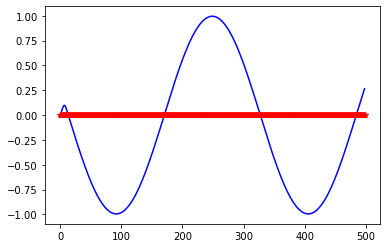

In [11]:
plt.plot(original_responses[11].T[1:], 'b')
plt.plot((original_responses - reconstructed_responses.real)[11].T[1:], '*r')
#plt.xlim([0, 7.])
plt.show()

In [12]:
np.abs(original_responses - reconstructed_responses).max()

5.509534031755692e-05

## Testing the reconstructed model

In [13]:
pulse = lambda t, args=0: 10. * np.sin(70. * t) # 1e-2* np.sin(2 * (t + 0.5 * t ** 2))

In [14]:
import copy
model = copy.deepcopy(reconstructed)

In [15]:
#model.Ac[:] = 0.5 * (model.Ac - model.Ac.conj().T)
#model.Nc[0][:] = 0.5 * (model.Nc[0] - model.Nc[0].conj().T)

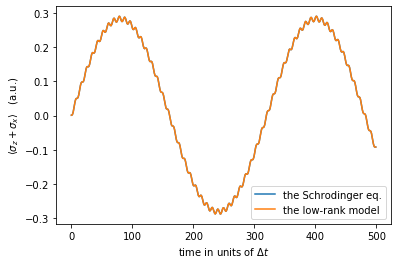

In [16]:
plt.plot(get_quantum_expectation(pulse, times), label='the Schrodinger eq.')
plt.plot(get_response(model, pulse, times), label='the low-rank model')

plt.xlabel("time in units of $\Delta t$")
plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")

plt.legend()
plt.savefig('Fig_LandauZener_Test.pdf')

plt.show()

In [17]:
np.linalg.eig(model.Ac)

(array([ 7.53944907e-10+1.99998545j,  7.53944907e-10-1.99998545j,
        -3.54864416e-07+0.j        ]),
 array([[-0.03717832+0.70583798j, -0.03717832-0.70583798j,
         -0.00324785+0.j        ],
        [ 0.70710678+0.j        ,  0.70710678-0.j        ,
         -0.02828712+0.j        ],
        [-0.02013093+0.00229338j, -0.02013093-0.00229338j,
          0.99959456+0.j        ]]))

In [18]:
(
    tensor(qeye(2), sigmaz()) - tensor(sigmaz(), qeye(2))
).eigenenergies()

array([-2.,  0.,  0.,  2.])

In [19]:
(
    tensor(qeye(2), sigmax()) - tensor(sigmax(), qeye(2))
).eigenenergies()

array([-2.0000000e+00,  0.0000000e+00,  6.9388939e-18,  2.0000000e+00])

In [20]:
np.linalg.eig(model.Nc[0])

(array([-2.17674605e-07+0.j        ,  3.64071337e-07+2.00000112j,
         3.64071337e-07-2.00000112j]),
 array([[-0.71065362+0.j        , -0.70320441+0.00062639j,
         -0.70320441-0.00062639j],
        [-0.70332201+0.j        ,  0.71035279+0.j        ,
          0.71035279-0.j        ],
        [ 0.01759487+0.j        , -0.02240308-0.02000454j,
         -0.02240308+0.02000454j]]))

In [21]:
reconstructed.Ac

array([[-1.05159098e-01, -2.00354971e+00, -5.70393254e-02],
       [ 2.00354971e+00,  1.05613226e-01,  9.49858033e-03],
       [-5.70393254e-02, -9.49858033e-03, -4.54481561e-04]])

In [22]:
"""
    l = 20 - 4

    transpose = np.array(
        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]
    )
        
    Phi = np.block([
        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],
        [np.zeros((l, 4)), np.eye(l)],
    ])

    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5
"""

'\n    l = 20 - 4\n\n    transpose = np.array(\n        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]\n    )\n        \n    Phi = np.block([\n        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],\n        [np.zeros((l, 4)), np.eye(l)],\n    ])\n\n    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5\n'